In [48]:
import pandas as pd
import numpy as np
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
%matplotlib inline
from sklearn import datasets, model_selection

In [4]:
df = pd.read_csv('datasets/winequalityN.csv')

In [5]:
df.head()

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,white,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,white,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,white,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,white,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [6]:
df.quality.unique()

array([6, 5, 7, 8, 4, 3, 9])

In [7]:
#Quality mapping to numbers from 0 to 6

quality_mapping = {
    3 : 0,
    4 : 1,
    5 : 2,
    6 : 3,
    7 : 4,
    8 : 5,
    9 : 6
}

In [8]:
df.loc[:,"quality"] = df.quality.map(quality_mapping)

In [9]:
df.quality.value_counts()

3    2836
2    2138
4    1079
1     216
5     193
0      30
6       5
Name: quality, dtype: int64

In [10]:
df.shape

(6497, 13)

In [11]:
df.dropna(inplace=True)

In [12]:
df.shape

(6463, 13)

In [13]:
# splitting training and test dataset
#shuffling dataset
df = df.sample(frac = 1).reset_index(drop = True)

df_train = df.head(5000)
df_test = df.tail(1463)

In [14]:
# Let's train using decision tree
clf = tree.DecisionTreeClassifier(max_depth = 3)

In [15]:
#except column 'type' and 'quality' use all other columns for training
cols = df_train.columns[~df_train.columns.isin(['type','quality'])]

In [16]:
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(max_depth=3)

In [17]:
#getting predictions on training set
train_predictions = clf.predict(df_train[cols])

In [18]:
#getting test predictions on test set
test_predictions = clf.predict(df_test[cols])

In [19]:
#Benchmark
#calulating training accuracy
training_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)

In [20]:
training_accuracy

0.5478

In [21]:
#calulating test accuracy
test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)

In [22]:
test_accuracy

0.49282296650717705

In [23]:
# increasing max_depth to 7 to increase the accuracy
clf = tree.DecisionTreeClassifier(max_depth = 7)

In [24]:
clf.fit(df_train[cols], df_train.quality)

DecisionTreeClassifier(max_depth=7)

In [25]:
#getting predictions on training set
train_predictions = clf.predict(df_train[cols])

In [26]:
#getting test predictions on test set
test_predictions = clf.predict(df_test[cols])

In [27]:
#calulating training accuracy
training_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)

In [28]:
training_accuracy

0.633

In [29]:
#calulating test accuracy
test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)

In [30]:
test_accuracy

0.5160628844839371

# Automating and creating plot for different max depths - what are the train and test accuracies


In [31]:
matplotlib.rc('xtick', labelsize = 20)
matplotlib.rc('ytick', labelsize = 20)

In [32]:
#initialize lists to store accuracies..lets start with 50% accuracy
train_accuracies = [0.5]
test_accuracies = [0.5]


In [33]:
#iterating over few max_depths

for depth in range(1,25):
    clf = tree.DecisionTreeClassifier(max_depth = depth)
    clf.fit(df_train[cols], df_train.quality)
    train_predictions = clf.predict(df_train[cols])
    test_predictions = clf.predict(df_test[cols])
    
    train_accuracy = metrics.accuracy_score(df_train.quality, train_predictions)
    test_accuracy = metrics.accuracy_score(df_test.quality, test_predictions)
    
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)
    


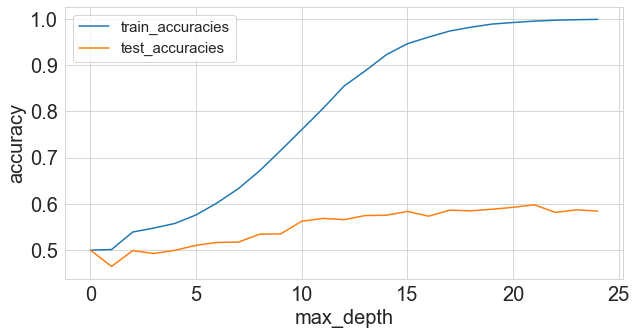

In [34]:
#Creating plot

plt.figure(figsize = (10,5))
sns.set_style("whitegrid")
plt.plot(train_accuracies, label ='train_accuracies')
plt.plot(test_accuracies, label = 'test_accuracies')
plt.legend(loc ='upper left', prop = {'size': 15})
plt.xticks(range(0,26,5))
plt.xlabel('max_depth', size = 20)
plt.ylabel('accuracy', size = 20)
plt.show()

Text(0, 0.5, 'Count')

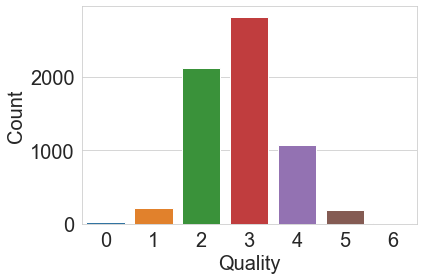

In [37]:
b = sns.countplot(x='quality', data = df)
b.set_xlabel('Quality', fontsize = 20)
b.set_ylabel('Count', fontsize = 20)

As the distribution is skewed, use stratified kfold cross validation. Thumb rule is, if it is standard classification problem, then go ahead with stratified kfold blindly.

# Occam's razor:
One should not try to complicate things when things can be solved in simple manner. In other words, if you are not statifying Occam's razor rule, then your model is probably overfitting.

# Sturge's Rule:
To calculate the number of bins if the data is small in a regression problem's target column to convert as a classification problem.

Number of bins = 1 + log2(N), N - number of samples 

# Using Stratified k fold cross validation in regression problem and create folds

In [42]:
    def create_folds(data):
        data["kfold"] = -1

        #shuffling data
        data = data.sample(frac = 1).reset_index(drop = True)

        #using sturge's rule, finding num_bins
        num_bins = int(np.floor(1+np.log2(len(data))))

        #creating bin target
        data.loc[:,"bins"] = pd.cut(data["target"], bins = num_bins, labels = False)

        #intializing stratified kfold
        kf = model_selection.StratifiedKFold(n_splits = 5)

        for f,(t_,v_) in enumerate(kf.split(X = data, y = data.bins.values)):
            data.loc[v_,"kfold"] = f

        #drop bins columns
        data.drop("bins", axis = 1, inplace = True)

        return data


In [49]:
if __name__ == "__main__":
    X,y = datasets.make_regression(n_samples = 15000, n_features = 100, n_targets = 1)
    
    #creating datasets from numpy array
    df = pd.DataFrame(X, columns = [f"f_{i}" for i in range(X.shape[1])])
    df.loc[:,"target"] = y
    
    df = create_folds(df)

/Users/egovsar/opt/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/model_selection/_split.py:672: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  % (min_groups, self.n_splits)), UserWarning)


Precision:
    What proportion of positive identifications was actually correct?

Recall:
    What proportion of actual positives was identified correctly?

# Confusion matrix

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

In [53]:
#some targets
y_true = [0,1,2,0,1,2,0,2,2]
y_pred = [0,2,1,0,2,1,0,0,2]

cm = metrics.confusion_matrix(y_true, y_pred)

Text(50.5, 0.5, 'Predicted labels')

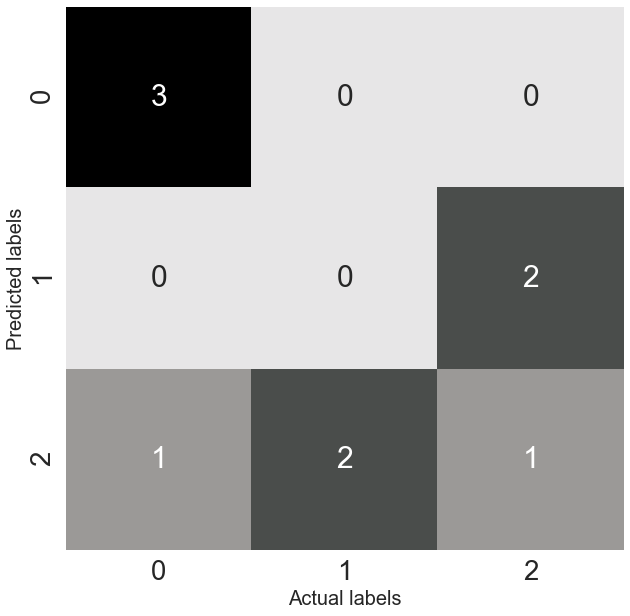

In [57]:
plt.figure(figsize = (10,10))
cmap = sns.cubehelix_palette(50, hue = 0.05, rot = 9, light = 0.9, dark = 0, as_cmap = True)
sns.set(font_scale = 2.5)
sns.heatmap(cm, annot = True, cmap = cmap, cbar = False)
plt.xlabel('Actual labels', fontsize = 20)
plt.ylabel('Predicted labels', fontsize = 20)

Multi label classification problem - One image can have multiple target associated with it. Eg. Identify all objects in a image. 